In [1]:
# Importando Bibliotecas

import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import os
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from IPython.display import display, Markdown

%matplotlib inline

In [2]:
# Função para requisitar e salvar o dataset

def load_dataset(path,urls):
#   Se o diretório recebido por parâmetro não existir, ele será criado
    if not os.path.exists(path):
        os.mkdir(path)
        
#   Para cada URL recebida por parâmetro, recebe o seu conteúdo e o escreve num arquivo criado no diretório
    for url in urls:
        data = requests.get(url).content
        filename = os.path.join(path, os.path.basename(url))
        with open(filename, "wb") as file:
            file.write(data)

In [3]:
urls = ["http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"]

# Solicitando a importação do Dataset contido nas URLS acima

load_dataset('data', urls)

In [4]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship","race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
 
#  Carregando o dataset com o Pandas
    
display(Markdown("**Dataset de Treino:**"))
display(Markdown("Variável Target: 'income'"))
train_data = pd.read_csv('data/adult.data', names=columns, sep=' *, *', na_values='?', engine='python') # Utiliza-se o separador ' *, *' para retirar os espaços em branco de cada campo e informa-se que os valores faltantes estão descritos como '?'
test_data = pd.read_csv('data/adult.test', names=columns, sep=' *, *', na_values='?', skiprows=1, engine='python') # Não adiciona a primeira linha ao dataset, pois ela contém lixo

train_data

**Dataset de Treino:**

Variável Target: 'income'

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [5]:
# Exibindo informações sobre os atributos do dataset de treinamento

display(Markdown("**Informações sobre os Atributos do dataset de Treinamento:**"))
train_data.info()

**Informações sobre os Atributos do dataset de Treinamento:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workClass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
# Exibindo informações sobre os atributos do dataset de teste

display(Markdown("**Informações sobre os Atributos do dataset de Teste:**"))
test_data.info()

**Informações sobre os Atributos do dataset de Teste:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workClass       15318 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education-num   16281 non-null  int64 
 5   marital-status  16281 non-null  object
 6   occupation      15315 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital-gain    16281 non-null  int64 
 11  capital-loss    16281 non-null  int64 
 12  hours-per-week  16281 non-null  int64 
 13  native-country  16007 non-null  object
 14  income          16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [7]:
# Contando a quantidade de valores faltantes nos atributos do dataset de treinamento

display(Markdown("**Quatidade de Valores Faltantes em cada Atributo do dataset de Treinamento:**"))
print(train_data.isnull().sum())
display(Markdown("- Como a quantidade de tuplas com valores faltantes é de, pelo menos, 5% do total, não é interessante descartar esses registros, pois se trata de uma quantidade expressiva"))

**Quatidade de Valores Faltantes em cada Atributo do dataset de Treinamento:**

age                  0
workClass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


- Como a quantidade de tuplas com valores faltantes é de, pelo menos, 5% do total, não é interessante descartar esses registros, pois se trata de uma quantidade expressiva

In [8]:
# Contando a quantidade de valores faltantes nos atributos do dataset de teste

display(Markdown("**Quatidade de Valores Faltantes em cada Atributo do dataset de Teste:**"))
print(test_data.isnull().sum())

**Quatidade de Valores Faltantes em cada Atributo do dataset de Teste:**

age                 0
workClass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


In [9]:
# Obtendo as labels dos atributos numéricos do dataset

display(Markdown("**Colunas Numéricas do dataset:**"))
num_attributes = train_data.select_dtypes(include=['int'])
num_attributes.columns

**Colunas Numéricas do dataset:**

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [10]:
# Obtendo as labels dos atributos categóricos do dataset

display(Markdown("**Colunas Categóricas do dataset:**"))
cat_attributes = train_data.select_dtypes(include=['object'])
cat_attributes.columns

**Colunas Categóricas do dataset:**

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')

In [11]:
# Obtendo estatísticas descritivas dos atributos numéricos do dataset de treinamento

display(Markdown("**Estatísticas Descritivas do dataset de Treinamento:**"))
train_data.describe()

**Estatísticas Descritivas do dataset de Treinamento:**

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [12]:
# Obtendo estatísticas descritivas dos atributos numéricos do dataset de teste

display(Markdown("**Estatísticas Descritivas do dataset de Teste:**"))
test_data.describe()

**Estatísticas Descritivas do dataset de Teste:**

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,13.849187,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [13]:
display(Markdown("- Os valores das estatísticas descritivas entre os dois datasets são semelhantes"))

- Os valores das estatísticas descritivas entre os dois datasets são semelhantes

**Frequência dos Valores das Variáveis Numéricas do dataset de Treinamento:**

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

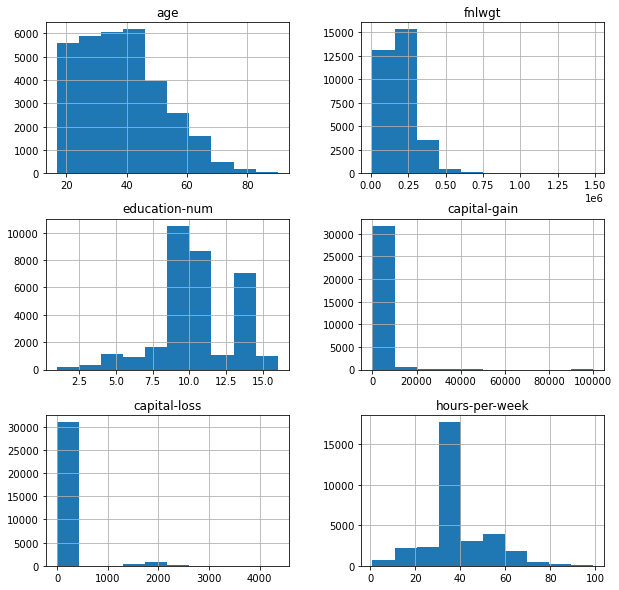

In [14]:
# Plotando as frequências relacionadas aos atributos numéricos

display(Markdown("**Frequência dos Valores das Variáveis Numéricas do dataset de Treinamento:**"))
num_attributes.hist(figsize=(10,10))

**Correlação entre as Variáveis Numéricas do dataset de Treinamento:**

<AxesSubplot:>

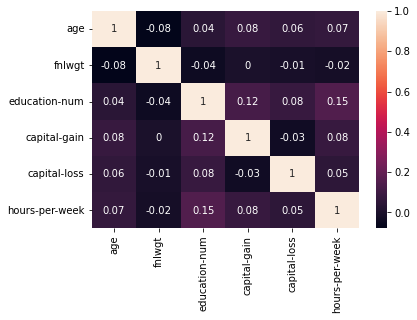

In [15]:
# Plotando a correlação entre as variáveis numéricas do dataset de treinamento

display(Markdown("**Correlação entre as Variáveis Numéricas do dataset de Treinamento:**"))
correlation_matrix = num_attributes.corr().round(2)
sns.heatmap(correlation_matrix, annot=True)

In [16]:
display(Markdown("- Pode-se observar que a correlação entre as variáveis listadas acima é muito baixa"))

- Pode-se observar que a correlação entre as variáveis listadas acima é muito baixa

**Frequência dos Valores das Variáveis Categóricas do dataset de Treinamento relacionada à Variável Target:**

<AxesSubplot:xlabel='count', ylabel='sex'>

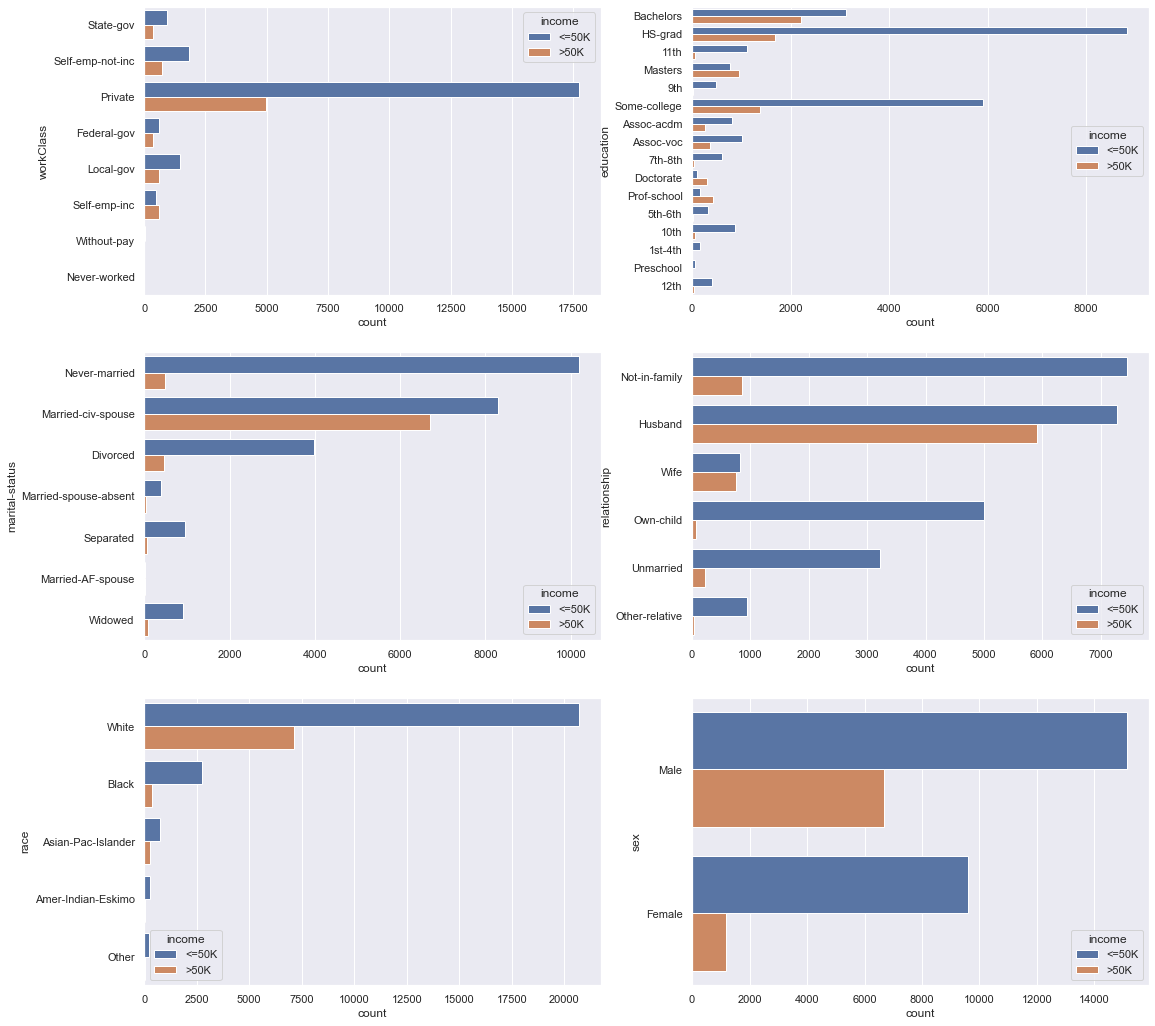

In [17]:
# Plotando a relação entre as variáveis categóricas independentes e a variável target

sns.set(rc={"figure.figsize":(18,18)})

display(Markdown("**Frequência dos Valores das Variáveis Categóricas do dataset de Treinamento relacionada à Variável Target:**"))
fig, ax = plt.subplots(3,2)

sns.countplot(ax=ax[0,0],data=cat_attributes, y='workClass', hue='income')
sns.countplot(ax=ax[0,1],data=cat_attributes, y='education', hue='income')
sns.countplot(ax=ax[1,0],data=cat_attributes, y='marital-status', hue='income')
sns.countplot(ax=ax[1,1],data=cat_attributes, y='relationship', hue='income')
sns.countplot(ax=ax[2,0],data=cat_attributes, y='race', hue='income')
sns.countplot(ax=ax[2,1],data=cat_attributes, y='sex', hue='income')

In [18]:
# Transformador que irá obter o(s) valor(es) da(s) coluna(s) de um dataframe passado por parâmetro, selecionando o(s) valor(es) pelo tipo desejado, também passado por parâmetro, do atributo

class ColumnSelector(BaseEstimator, TransformerMixin):
    
#   Construtor recebe o tipo desejado do atributo  
    def __init__(self, type):
        self.type = type
    
    def fit(self, X, y=None):
        return self
      
#   Retorna o(s) valor(es) correspondente(s) da(s) coluna(s) selecionada(s)      
    def transform(self,X):
        return X.select_dtypes(include=[self.type])
    

In [19]:
# Constrói um pipeline para aplicar múltiplas transformações

num_pipeline = Pipeline(steps=[
#   Obtem-se as colunas numéricas 
    ("num_attr_selector",ColumnSelector(int)),
#   Normaliza os valores obtidos anteriormente para que obtenham média igual a zero e desvio padrão igual a um  
    ("Scaler", StandardScaler())
])

In [20]:
# num_pipeline.fit_transform(train_data)

In [21]:
# Transformador que irá imputar o(s) valor(es) faltante(s) de um dataframe passado por parâmetro

class CategoricalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=None, strategy='most_frequent'):
        self.columns = columns
        self.strategy = strategy
        
    def fit(self, X, y=None):
#       Se a instância não houver colunas, atribui a ela as colunas passadas como parâmetro na função fit  
        if self.columns is None:
            self.columns = X.columns
    
#       Se a estratégia da instância for 'most_frequent', preenche uma lista (fill) com o valor de maior frequência de cada coluna
        if self.strategy is 'most_frequent':
            self.fill = {column: X[column].value_counts().index[0] for column in self.columns}

        return self
     
    def transform(self,X):
#       Faz uma cópia do dataset e preenche os valores faltantes de cada coluna com o respectivo valor contido na lista 'fill'  
        x_copy = X.copy()
        for column in self.columns:
            x_copy[column] = x_copy[column].fillna(self.fill[column])
            
        return x_copy

<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\gabriel.felix\AppData\Local\Temp\ipykernel_12692\4168260613.py:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.strategy is 'most_frequent':


In [22]:
# Transformador que irá discretizar o(s) atributo(s) categórico(s) de um dataframe passado por parâmetro

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, dropFirst=True):
        self.categories = dict()
        self.dropFirst = dropFirst
        
    def fit(self, X, y=None):
#       Concatena os dataframes de treino e teste  
        join_df = pd.concat([train_data, test_data])
#       Obtém apenas as colunas categóricas
        join_df = join_df.select_dtypes(include=['object'])
#       Adiciona cada coluna categórica ao dicionário 'categories' com o nome da coluna como chave e uma lista com os índices dos valores da coluna como valor
        for column in join_df.columns:
            self.categories[column] = join_df[column].value_counts().index.tolist()
            
        return self
    
    def transform(self, X):
#       Faz uma cópia do dataset e obtém apenas as colunas categóricas  
        x_copy = X.copy()
        x_copy = x_copy.select_dtypes(include=['object'])
#       Converte o tipo da coluna para respectivo tipo do valor armazenado no dicionário 'categories'  
        for column in x_copy.columns:
            x_copy[column] = x_copy[column].astype({column: CategoricalDtype(self.categories[column])})
            
#       Converte e retorna os atributos categóricos em indicadores (dummy) do dataframe cópia      
        return pd.get_dummies(x_copy, drop_first=self.dropFirst)

In [23]:
# Constrói um pipeline para aplicar múltiplas transformações

cat_pipeline = Pipeline(steps=[
#   Obtem-se as colunas categóricas 
    ('cat_attr_selector', ColumnSelector(object)),
#   Imputa-se os valores faltantes para as colunas especificadas  
    ('cat_imputer', CategoricalImputer(columns=['workClass', 'occupation', 'native-country'])),
#   Codifica-se as variáveis categóricas, transformando-as em indicadoras numéricas discretizadas  
    ('encoder', CategoricalEncoder())
])

In [24]:
# Constrói uma FeatureUnion para aplicar múltiplos pipelines

full_pipeline = FeatureUnion([
    ('num_pipe', num_pipeline),
    ('cat_pipe', cat_pipeline)
])

In [25]:
# Retira as colunas 'fnlwgt' e 'education' do dataset

train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

In [26]:
# Faz uma cópia do dataset de treino e de teste e discretiza a variável target, tornando-a numérica

train_copy = train_data.copy()
train_copy['income'] = train_copy['income'].apply(lambda x: 0 if x=='<=50K' else 1)

test_copy = test_data.copy()
test_copy['income'] = test_copy['income'].apply(lambda x: 0 if x=='<=50K.' else 1)

# Separa os datasets em variáveis independentes (x) e variável target (y), de treinamento (train) e de teste (test)

x_train = train_copy.drop('income', axis=1)
y_train = train_copy['income']
x_test = test_copy.drop('income', axis=1)
y_test = test_copy['income']

In [27]:
# Aplica as transformações numéricas e categóricas no dataset de variáveis independentes

x_train_processed = full_pipeline.fit_transform(x_train)
x_test_processed = full_pipeline.fit_transform(x_test)

# Constrói um modelo de regressão logística e o ajusta com as variáveis independentes e com a variável target transformadas

model = LogisticRegression(random_state=0, max_iter=1000, solver='liblinear')
model.fit(x_train_processed, y_train)

LogisticRegression(max_iter=1000, random_state=0, solver='liblinear')

In [28]:
# Solicita a predição do valor target das amostras de treinamento e de teste

predicted_train_classes = model.predict(x_train_processed)
predicted_test_classes = model.predict(x_test_processed)

In [29]:
# Calcula a assertividade relativa da predição do modelo sobre o dataset de treinamento

display(Markdown("**Acurácia do modelo de Regressão Logística para o dataset de treinamento:**"))
accuracy_score(predicted_train_classes, y_train.values)

**Acurácia do modelo de Regressão Logística para o dataset de treinamento:**

0.8513559165873285

In [30]:
# Calcula a assertividade relativa da predição do modelo sobre o dataset de teste

display(Markdown("**Acurácia do modelo de Regressão Logística para o dataset de teste:**"))
accuracy_score(predicted_test_classes, y_test.values)

**Acurácia do modelo de Regressão Logística para o dataset de teste:**

0.8524660647380382

**Matriz de Confusão dos valores Preditos pelo modelo de Regressão Logística:**

Text(138.5, 0.5, 'Actual Classes')

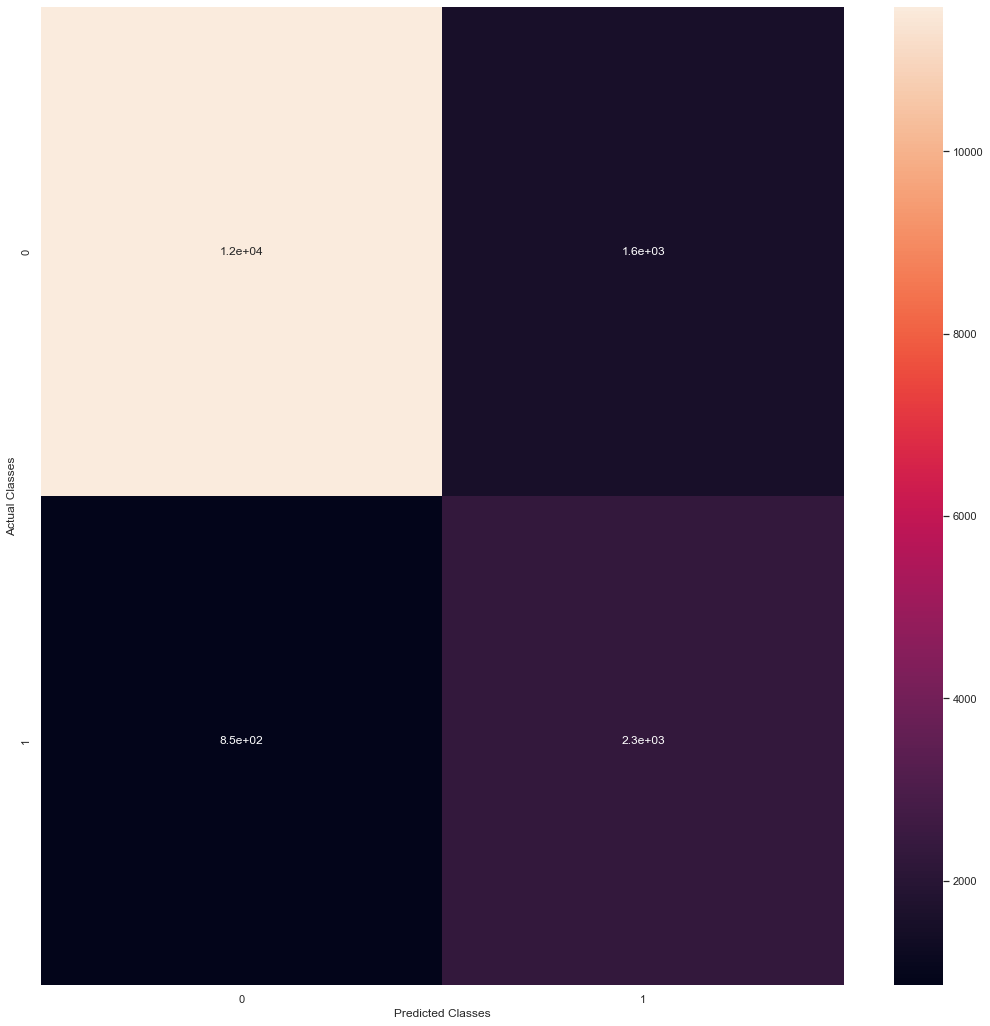

In [32]:
# Calcula e plota a matriz de confusão das predições do modelo sobre o dataset de teste

display(Markdown("**Matriz de Confusão dos valores Preditos pelo modelo de Regressão Logística:**"))
cfm = confusion_matrix(predicted_test_classes, y_test.values)
sns.heatmap(cfm, annot=True)
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')

In [41]:
# Calcula o Cross Validation utilizando Stratified KFold com 10 grupos e exibe a média dos scores obtidos

display(Markdown("**Score médio do Stratified KFold (K=10) do modelo de Regressão Logística para o dataset de treinamento:**"))
scores = cross_val_score(model, x_train_processed, y_train, cv=10)
print(np.mean(scores))
display(Markdown("- Em média, o modelo acerta 85% das predições"))

**Score médio do Stratified KFold (K=10) do modelo de Regressão Logística para o dataset de treinamento:**

0.8505882529332023


- Em média, o modelo acerta 85% das predições

In [42]:
# Calcula o Cross Validation utilizando Stratified KFold com 10 grupos e exibe a média dos scores obtidos

display(Markdown("**Score médio do Stratified KFold (K=10) do modelo de Regressão Logística para o dataset de teste:**"))
scores = cross_val_score(model, x_test_processed, y_test, cv=10)
print(np.mean(scores))
display(Markdown("- Em média, o modelo acerta 85% das predições"))

**Score médio do Stratified KFold (K=10) do modelo de Regressão Logística para o dataset de teste:**

0.8501328802433775


- Em média, o modelo acerta 85% das predições

In [34]:
display(Markdown("**Melhores parâmetros para a Regularização:**"))
# Define os tipos de regularização a serem avaliados
penalty = ['l1', 'l2']

# Define o intervalo do inverso do parâmetro de ajuste a ser avaliado
c = np.logspace(0, 4, 10)

random_state=[0]

# Define o dicionário de hiperparâmetros com as informações acima
hyperparameters = dict(C=c, penalty=penalty, random_state=random_state)

# Constrói a grade de avaliação de valores de parãmetros para o estimador utilizando o modelo criado anteriormente, os hyperparâmetros definidos acima e um cross-validation de 10 folds para avaliação
clf = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=10)

# Constrói um modelo de regressão logística regularizado a partir da grade de avaliação acima
best_model = clf.fit(x_train_processed, y_train)

print('Tipo da Regularização:', best_model.best_estimator_.get_params() ['penalty'])
print('Inverso do Parâmetro de Ajuste:', best_model.best_estimator_.get_params()['C'])

**Melhores parâmetros para a Regularização:**

Tipo da Regularização: l1
Inverso do Parâmetro de Ajuste: 7.742636826811269


In [35]:
display(Markdown("**Acurácia do modelo de Regressão Logística para o dataset de treinamento após a Regularização:**"))
best_predicted_train_values = best_model.predict(x_train_processed)
accuracy_score(best_predicted_train_values, y_train.values)

**Acurácia do modelo de Regressão Logística para o dataset de treinamento após a Regularização:**

0.8514787629372562

In [36]:
display(Markdown("**Acurácia do modelo de Regressão Logística para o dataset de teste após a Regularização:**"))
best_predicted_test_values = best_model.predict(x_test_processed)
accuracy_score(best_predicted_test_values, y_test.values)

**Acurácia do modelo de Regressão Logística para o dataset de teste após a Regularização:**

0.8522818008721823

In [37]:
display(Markdown("- A proximidade das acurácias para as predições dos datasets de treinamento e de teste aumentou após a regularização do modelo"))

- A proximidade das acurácias para as predições dos datasets de treinamento e de teste aumentou após a regularização do modelo

In [38]:
display(Markdown("**Score médio do Stratified KFold (K=10) do modelo de Regressão Logística para o dataset de treinamento após a Regularização:**"))
print(best_model.best_score_)
display(Markdown("- Em média, o modelo acerta 85% das predições"))

**Score médio do Stratified KFold (K=10) do modelo de Regressão Logística para o dataset de treinamento após a Regularização:**

0.8508031840699941


- Em média, o modelo acerta 85% das predições

In [39]:
display(Markdown("**Score médio do Stratified KFold (K=10) do modelo de Regressão Logística para o dataset de teste após a Regularização:**"))
best_scores = cross_val_score(best_model, x_train_processed, y_train, cv=10)
print(np.mean(best_scores))
display(Markdown("- Em média, o modelo acerta 85% das predições"))
display(Markdown("- A variação da eficiência do modelo com e sem a regularização não foi significativa para o dataset em questão"))

**Score médio do Stratified KFold (K=10) do modelo de Regressão Logística para o dataset de teste após a Regularização:**

0.8505882623629016


- Em média, o modelo acerta 85% das predições

- A variação da eficiência do modelo com e sem a regularização não foi significativa para o dataset em questão

In [40]:
display(Markdown("- A proximidade dos scores para as predições dos datasets de treinamento e de teste descarta a hipótese de sobreajuste do modelo"))

- A proximidade dos scores para as predições dos datasets de treinamento e de teste descarta a hipótese de sobreajuste do modelo